## ASTR 21000, Winter 2020

## Homework Assignment 5 (55 points + 20 extra-credit exercise points)

### Distributed: Monday, March 2

### Due: Friday,  March 6 at 11:59pm 

import packages needed by the codes below. Run this cell first before using these codes. 

In [2]:
import numpy as np

# use jupyter "magic" command to tell it to embed plot into the notebook 
import matplotlib.pyplot as plt
plt.rc('text', usetex=True)
%matplotlib inline

from codes.plot_utils import plot_pretty
from codes.plot_utils import plot_line_points

plot_pretty(fontsize=12)

### Introduction 

In this homework you will redo the analysis you did in homework 3 using supernovae to constrain model parameters but with a different approach. There are two differences in the approach you will use in this exercise: 

1) you will work with the *likelihood function* instead of $\chi^2$. The likelihood function and the rationale for its use, as well as relation of $\chi^2$ to this function were introduced in the lab and you can find the description in <a href="07_model_parameter_inference.ipynb"><tt>07_model_parameter_inference.ipynb</tt></a> notebook. More precisely, you will work with the likelihood function and prior probability distributions for model parameters, which combined give the pdf called *posterior distribution function*. 

2) you will use the model that abandons assumption that supernovae type Ia are "standard candles" (i.e. have the same absolute magnitude value $M_0$). Instead, the absolute magnitude of each supernova will be corrected using two of its properties measured in observations. This requires two additional parameters, which brings the number of model parameters from 3 to 5. 

Thus, we have to map out the likelihood in 5-dimensional model parameter space, which cannot be easily done by sampling on a grid as could be done for 3D parameter space in homework 3. Thus, in the two exercises in this homework you will first find the "best fit" model parameters in the first exercise and then will learn how to estimate uncertainties by sampling 5-dimensional posterior distribution. 

### Exercise 1: using supernova type Ia sample to measure the average density of matter and vacuum energy in our Universe: final analysis using likelihood function and priors (40 points)

#### What are you learning in this exercise

1. How to esimate parameters using likelihood, priors, and minimization of the -posterior distribution

2. How to map multi-dimensional posterior distribution using MCMC sampling and how to estimate confidence levels of parameters. 

#### Background:

The model described in <a href="hw03.ipynb"><tt>hw03.ipynb</tt></a> has 3 parameters: $\Omega_{\rm m0}$, $\Omega_\Lambda$, $\tilde{M_0}$ and predicts the difference between observed and model distance modulus to be: 

\begin{eqnarray}
\Delta\mu=\mu_{\rm obs} - \mu(z,\Omega_{\rm m0},\Omega_\Lambda) &=&m_{\rm SNIa} - M_0 - 5\log_{10}\tilde{d}_L(z,\Omega_{\rm m0},\Omega_\Lambda) - 5\log_{10}c + 5\log_{10}H_0 - 25\\
&=& m_{\rm SNIa} - 5\log_{10}\tilde{d}_L(z,\Omega_{\rm m0},\Omega_\Lambda) - \tilde{M}_0, 
\end{eqnarray}

where 

$$ \tilde{M}_0 = \left(M_0 + 5\log_{10}\,\frac{c}{H_0}+25\right).$$

This model assumes that the same absolute magnitude, $M_0$ (a measure of intrinsic supernova luminosity), is the same for all supernova. Objects for which this is true are called "standard candles" in astronomy. This is not a bad assumption. For decades astronomers did think that supernovae type Ia are standard candles. However, about 30 years ago it was shown that this is not quite true. Intrinsic absolute magnitude of supernovae of this type varies, but the variation occurs not randomly, but systematically as a function of supernova color (difference of magnitudes in different bands) and the characteristic time it takes for a supernova brightness to fade from its peak brightness. 

Both of these properties are observable and are characterized by the color parameter, $c$, related to supernova color at peak brightness and lightcurve stretch parameter, $x_1$. Astronomers found that the parameter nearly constant for all supernovae is not $M_0$ ($M_0$ varies), but the combination $M_0 - \alpha x_1 + \beta c$, where $\alpha$ and $\beta$ are parameters that are constant for all supernovae. $M_0$,  and $\alpha$ and $\beta$ are *nuisance* parameters of the model and have to be estimated from the data itself. 

Thus, we can modify our model for the distance modulus by including these two extra parameters: 

$$
\Delta\mu=\mu_{\rm obs} - \mu(z,\Omega_{\rm m0},\Omega_\Lambda)= m_{\rm SNIa} - 5\log_{10}\tilde{d}_L(z,\Omega_{\rm m0},\Omega_\Lambda) - \tilde{M}_0 + \alpha x_1 - \beta c,$$ 

with the vector of 5 parameters $\mathbf{x}=\{\Omega_{\rm m0},\Omega_\Lambda, \tilde{M}_0, \alpha,\beta\}$ and $x_1$ and $c$ stretch and color parameters measured for each supernova. 

These parameters are available in the data file that we've been using along with their observational uncertainties and can be read as shown below along with other quantities we've used previously. 

### Observational sample of supernovae type Ia

We will use the same sample of 740 supernovae published in a study of 
<a href="https://ui.adsabs.harvard.edu/abs/2014A%26A...568A..22B/abstract">Betoule et al. (2014)</a>. The file containing the sample is available in the course repository and was downloaded from <a href="http://supernovae.in2p3.fr/sdss_snls_jla/ReadMe.html">here</a>. However, we will now also use $x_1$ and $c$ stretch and color parameters measured for each supernova and their uncertainties, as shown below. 

In [3]:
#zCMB, mB, emB were used before in hw 3
# x1 and ex1 are stretch parameter measured for each SN and its uncertainty
# csn and ecsn are color parameter and its uncertainty
zCMB, mB, emB, x1, ex1, csn, ecsn = np.loadtxt('data/jla_lcparams.txt', 
                                               usecols=(1, 4, 5, 6, 7, 8, 9), unpack=True)

print("read sample of %d supernovae..."%(np.size(zCMB)))

read sample of 740 supernovae...


In [4]:
#Set up parameters
from codes.cosmology import d_L_romberg
from scipy.interpolate import RectBivariateSpline
from codes.cosmology import d_L_vectorized
from codes.plot_utils import plot_color_map

clight = 2.99792458e5 # c in km/s
z, H0 = 2.0, 70.
Om0min, Om0max, OmLmin, OmLmax = 0., 1.,0.,1.
ntr = 10

def lum_grid(z, H0, Om0_vec, OmL_vec, atol=2.e-15, rtol=2.e-15):
    """
    helper function returns a grid of dL (scaled by H0/c)
    with n x n dimensions
    where n = the length of the Om0 and OmL vectors
    """
    n = np.size(Om0_vec)
    grid = np.zeros([n,n])
    for i in range(n):
        for j in range(n):
            grid[i][j] = (H0/clight)*d_L_vectorized(z, H0, Om0_vec[i], OmL_vec[j], atol=atol, rtol=rtol)
            #grid[i][j] = lum_scale(z, H0, Om0_vec[i],OmL_vec[j])
    return grid

def chebyshev_nodes1(a, b, N):
    return a + 0.5*(b-a)*(1. + np.cos((2.*np.arange(N+1)+1)*np.pi/(2.*(N+1))))

def polyfit2d(xtr, ytr, ftr, kx=3, ky=3, order=None):
    '''
    Returns polynomial spline coefficients for 2D polyfit w/ least squares
    
    Parameters:
    xtr, ytr: array-like, 1d
        xtr and ytr coordinates.
    ftr: 2d numpy array
        f(xgtr, ygtr) values evaluated on meshgrid of xtr and ytr vectors to fit by polynomial
    kx, ky: int, default is 3
        Polynomial order in x and y, respectively.
    order: int or None, default is None
    '''
    # grid coords
    x, y = np.meshgrid(xtr, ytr)
    # coefficient array, up to x^kx, y^ky
    coeffs = np.ones((kx+1, ky+1))

    # solve array
    V = np.zeros((coeffs.size, x.size))

    # construct Vandermonde matrix: for each coefficient produce array x^i, y^j
    for index, (j, i) in enumerate(np.ndindex(coeffs.shape)):
        # do not include powers greater than order
        if order is not None and i + j > order:
            arr = np.zeros_like(x)
        else:
            arr = coeffs[i, j] * x**i * y**j
        V[index] = arr.flatten()
        
    # do leastsq fitting and return leastsq result
    return np.linalg.lstsq(V.T, np.ravel(ftr), rcond=None)[0]

dLz = []
ntest = 100

Om0tr = chebyshev_nodes1(Om0min, Om0max, ntr-1)[::-1]
OmLtr = chebyshev_nodes1(OmLmin, OmLmax, ntr-1)[::-1]

Om0 = np.linspace(Om0min, Om0max, ntest)
OmL = np.linspace(OmLmin, OmLmax, ntest)

Om0_grid, OmL_grid = np.meshgrid(Om0, Om0, sparse=False, indexing='ij')

for iz, zi in enumerate(zCMB):
    #generate spline coefficients for dL approximation for each value of z
    px, py = 14,14
    dLtr_poly = lum_grid(zi, H0, Om0tr, OmLtr) #initalize training grid
    a = polyfit2d(Om0tr, OmLtr, dLtr_poly, kx=px, ky=py, order=None) #fit spline to data 
    dLz.append(a)

#### Group work

If you feel that your group work in hw 3 was productive, I encourage you to continue working with your group. You can also form a new group, if you wish. In this type of exercise it is helpful to discuss approach and results in a group and such collaborative work is encouraged. 

**Task 1a. (10 points)** Write a routine that computes $\ln L$ for this new 5-parameter model, where 

$$\ln L(\mathbf{y}\vert\mathbf{x}) = -\frac{1}{2}\,\sum\limits_{i=0}^{N_{\rm SN}-1}\frac{\Delta\mu^2}{\sigma_{\Delta\mu,i}^2}$$

and $\sigma_{\Delta\mu,i}^2$ is total uncertainty of the observational estimate of the distance modulus that accounts for uncertainties in $m_B$, $x_1$, and $c$, which by rules of error propagation is: 

$$\sigma_{\Delta\mu,i}^2 = \sigma_{m_B}^2 + \alpha^2\sigma_{x1}^2 + \beta^2\sigma_c^2,$$

which means that the error also depends on the two model parameters, $\alpha$ and $\beta$. 

 

In [5]:
from scipy.optimize import differential_evolution as de
def fit_dl(Om0_vec, OmL_vec, a):
    Om0_grid, OmL_grid = np.meshgrid(Om0_vec, OmL_vec, sparse=False, indexing='ij')
    fitted = np.polynomial.polynomial.polyval2d(Om0_grid, OmL_grid, a.reshape((px+1,py+1)))
    return fitted
def logL2(x):
    """
    Parameters:
    x: vector containing Om0, OmL, tM0, alpha, beta
    
    Returns:
    -2 ln(L)
    """
    Omega0, OmegaL, tildeM0, a, b = x
    logLZ = 0

    for iz, zi in enumerate(zCMB):
        dL = fit_dl(Omega0, OmegaL, dLz[iz])
        dMu = mB[iz]-5*np.log10(dL)-tildeM0+a*x1[iz]-b*csn[iz]
        
        sigma2 = emB[iz]**2 + (a*ex1[iz])**2 + (b*ecsn[iz])**2
        lTemp = (dMu**2)/sigma2
        logLZ = logLZ + lTemp
    return logLZ

**Task 1b. (8 points)** Test your routine by using the differential evolution routine you implemented in hw 4, or <a href="https://docs.scipy.org/doc/scipy-0.15.1/reference/generated/scipy.optimize.differential_evolution.html"><tt>scipy.minimize.differential_evolution</tt></a> routine to find parameters that minimize $-2\ln L$ and print them out. 

To define bounds, you can use ranges for $\Omega_{\rm m0}$ and $\Omega_\Lambda$ of $[0,1]$ and for $\tilde{M}_0$ say $[20, 28]$. For $\alpha$ good choice for range is $[0.05, 0.3]$ and for $\beta$: $[1., 5.]$. Feel free to experiment with these ranges. 

The values for $\Omega_{\rm m0}$ and $\tilde{M}_0$ you should get should be quite similar (although not exactly the same) as in hw 3, but $\Omega_\Lambda$ should change quite a bit. 
Describe the changes from the values derived in hw 3 and compare the parameters you derive.



In [15]:
from scipy.optimize import differential_evolution
#define bounds for minimization
bounds = [(0,1.),(0,1.),(20.,28.),(0.05,0.3),(1.,5.)]

result = differential_evolution(logL2, bounds)

print(result.x, result.fun)

[ 0.25203038  0.70298461 24.07511097  0.12999475  3.17390659] [[622.71339167]]


**Task 1c (2 points).** Compute the reduced $\chi^2$ for the values of the parameters that minimize the $-2\ln L$. What can you conclude about how well the model describes the supernova measurements? How does the value compares to the value obtained in hw3?

In [12]:
def redChi2(params):
    Omega0, OmegaL, tildeM0, a, b = params
    
    chiZ = np.empty(np.size(zCMB))
    for i, zi in enumerate(zCMB):
        #dL approx corresponding to the ith supernova
        dL_approx = fit_dl(Omega0, OmegaL, dLz[i]) #2d grid for supernova
        dMu = mB[i] - 5*np.log10(dL_approx) - tildeM0 +a*x1[iz]-b*csn[iz]
        sigma2 = emB[iz]**2 + (a*ex1[iz])**2 + (b*ecsn[iz])**2
        chiZ[i] = (dMu**2)/sigma2
    
    #return reduced chi2 value
    return np.sum(chiZ)/(len(zCMB) - len(params))

redChi2(result.x)

3.6810196310300016

**Task 1d. (10 points)** Write a function that defines natural logarithm of prior pdf for all parameters $\ln p$. Write another function that defines unnormalized posterior pdf, i.e.  combines $\ln L$ and $\ln p$ into $\ln L(\mathbf{y}\vert\mathbf{x}) + \ln p(\mathbf{x})=\ln L(\mathbf{y}\vert\mathbf{x})p(\mathbf{x})$. For $p$ for all parameters you can assume uniform pdf defined between minimum and maximum value you choose for each parameter (these should be $0$ and $1$ for $\Omega_{\rm m0}$ and $\Omega_\Lambda$ not to extrapolate your approximation for $\tilde{d}_L$. The total prior pdf for all parameters is a product of prior pdfs for individual parameters. (4 points)

Use example routine <tt>vectorized_mcmc</tt> from <a href="06d_multid_sampling_mcmc.ipynb"><tt>06d_multid_sampling_mcmc.ipynb</tt></a> notebook or <tt>emcee</tt> package to sample $\ln L(\mathbf{y}\vert\mathbf{x})p(\mathbf{x})$ using MCMC. Plot resulting distributions of chain values for $\Omega_{\rm m0}$ and $\Omega_\Lambda$ along with the confidence contours that correspond to $1-$ and $2-\sigma$ of the Gaussian distribution and enclose $0.6827$ and $0.9545$ of the total posterior probability using <tt>plot_2d_distribution</tt> routine from <tt>codes/plot_utils.py</tt> (6 points). 

Examples of usage of 
<tt>vectorized_mcmc</tt> and <tt>emcee</tt> and <tt>plot_2d_distribution</tt> routine to plot distribution of MCMC samples and confidence contours can be found in <a href="06d_multid_sampling_mcmc.ipynb"><tt>06d_multid_sampling_mcmc.ipynb</tt></a> notebook. 

In [6]:
from numpy.random import uniform

vec = [0.5, 0.5, 25, 0.20, 3]

minParam = [0, 0, 20, 0.05, 1.]
maxParam = [1.,1.,28.,0.3,5.]
    
def prior(x):
    #compute vector of prior values for input vector of Om0, OmL, tM0, alpha, beta
    p = np.zeros([1,5])
    for i in range(0,len(x)):
        if (x[i] >= minParam[i]) & (x[i] <= maxParam[i]):
            p[0][i] = 1
        else:
            p[0][i] = 0
            
    total = np.prod(p)
    if total == 0:
        return -500
    else:
        return np.log(total)

def posterior(x):
    return logL2(x)+np.log(prior(x))


In [7]:
def vectorized_mcmc(x, nsteps=1, step=0.1, modelpdf = None, args = None):
    """
    MCMC sampler implementing a simple Metropolis algorithm
    to follow a number of chains ("walkers") in parallel
    
    This version also can sample distributions of arbitrary number of 
    dimensions ndim
    
    Parameters:
    ------------
    x0 - a real numpy array of size [nwalkers,ndim]
        initial x value
    nsteps - integer
        number of MCMC steps (iterations) to take
    step - float
        step size controlling step proposal distribution
    modelpdf - python function object
        ln(pdf) where pdf is the target pdf to sample
    args - pointer to a list
        list of arguments to pass modelpdf
        
    Returns:
    ---------
    xchain - numpy array of size [nsteps*nwalkers, ndim]
        coordinates of samples in the MCMC chains of size
    pacc   - float
        acceptance ratio of the MCMC steps (ratio of accepted to the total proposed number of steps)
    
    """
    
    # the input array here contains initial values for multiple MCMC sequences
    # or "walkers" in the MCMC jargon (because they "walk" the multi-d space of our target pdf)
    nwalkers = np.shape(x)[0]
    print("nwalkers:",nwalkers)
    # make sure input is sensible
    assert(nwalkers>0)
    
    # number of dimensions that we will be sampling
    ndim = np.shape(x)[1]
    print("ndim:",ndim)
        
    # initialize some auxiliary arrays and variables 
    chain = np.empty_like(x);

    naccept = 0; ntry = 0; nchain = 0
    # initialize arrays that will be used to hold pdf values of samples
    # at old and proposed sample locations
    gxold = np.empty(nwalkers)
    gxtry = np.empty(nwalkers)
    for i in range(nwalkers):
        gxold[i] = modelpdf(x[i,:], *args)
    
    nsample = 0 
    while nsample < nsteps:
        # proposal step using uniform pdf in range [-step, step]
        xtry  = x + step*np.random.uniform(-step, step, np.shape(x)) 
        for i in range(nwalkers):
            gxtry[i] = modelpdf(xtry[i,:], *args) 
        gx = np.copy(gxold) 
        # compare pdf values at the old and proposed sample locations  
        gr   = gxtry - gx
        u = np.random.uniform(0.0,1.0,np.shape(x)[0])
        # accept proposal with probability min[1.0, e^gr]
        iacc = np.where(gr > np.log(u)) 
        # update those "walkers" for which proposal step was accepted 
        x[iacc,:] = xtry[iacc,:]
        gxold[iacc] = gxtry[iacc]
        naccept += np.size(gxtry[iacc])
        # add all walkers to the chain, regardless of whether their proposal step was accepted
        chain = np.vstack((chain, x))

        nsample += 1
        

    return chain, 1.*naccept/(nsample*nwalkers)

In [12]:
nwalk = 10
ndim = 5
mcOm0 = np.linspace(0,1,4)
mcOmL = np.linspace(0,1,4)
mctm0 = np.linspace(20.,28.,4)
mcA = np.linspace(0.05,0.3,4)
mcB = np.linspace(1.,5.,4)
x0 = np.stack((mcOm0, mcOmL, mctm0, mcA, mcB), axis=-1)
#posterior(x0)
vectorized_mcmc(x0, modelpdf=posterior,args=[])

nwalkers: 4
ndim: 5


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: divide by zero encountered in log
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in log
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:61: RuntimeWarning: invalid value encountered in subtract
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:64: RuntimeWarning: invalid value encountered in greater


(array([[ 0.        ,  0.        , 20.        ,  0.05      ,  1.        ],
        [ 0.33333333,  0.33333333, 22.66666667,  0.13333333,  2.33333333],
        [ 0.66666667,  0.66666667, 25.33333333,  0.21666667,  3.66666667],
        [ 1.        ,  1.        , 28.        ,  0.3       ,  5.        ],
        [ 0.        ,  0.        , 20.        ,  0.05      ,  1.        ],
        [ 0.33333333,  0.33333333, 22.66666667,  0.13333333,  2.33333333],
        [ 0.66666667,  0.66666667, 25.33333333,  0.21666667,  3.66666667],
        [ 1.        ,  1.        , 28.        ,  0.3       ,  5.        ]]),
 0.0)

**Task 1e (10 points).** Experiment with different number of MCMC steps and compute the correlation time for the chain in each case (using <tt>compute_tcorr</tt> routine below). What chain length is acceptable to get a reasonable plot for the posterior distribution and sufficient statistics of nearly independent samples $N_{\rm chain}/t_{\rm corr}$? 

Present the plot of distribution of the MCMC chain samples in the $\Omega_{\rm m0}-\Omega_\Lambda$ along with the contours enclosing $0.6827$ and $0.9545$ of the total posterior probability. Compare them to the results you obtained in hw 3. What are the main differences?

In [ ]:
def auto_corr_func(timeseries, lagmax):
    """
    compute auto correlation function
    """
    ts = np.asarray(timeseries)
    N = np.size(ts) - 1
    ts -= np.average(ts) # Set to mean 0
    corr_func = np.zeros(lagmax)
    for dt in range(lagmax):
        # sum of ts[t+dt]*ts[t]
        corr_func[dt] = (np.dot(timeseries[0:N-dt],timeseries[dt:N])) 
    if (corr_func[0]>0):
        corr_func /= corr_func[0] # normalize
    return corr_func

def compute_tcorr(timeseries,maxcorr):
    """
    compute auto-correlation time
    Parameters:
    -----------
    
    timeseries: 1d vector of values
    maxcorr: maximum autocorrelation lag to consider
    
    Returns:
    tau, mean, sigma: float scalars
        autocorrelation time, mean of the sequence and its rms 
    """
    timeseries = np.copy(timeseries)
    mean = np.average(timeseries)
    corrfxn = auto_corr_func(timeseries,maxcorr)
    tau = np.sum(corrfxn)-1
    var = np.var(timeseries)
    sigma = np.sqrt(var * tau / len(timeseries))
    return tau, mean, sigma


### Exercise 2. Volume of the $D$-dimensional unit sphere using Monte-Carlo method (15 points)


#### Task 2a. Routine to estimate volume of $D$-dimensional sphere using Monte Carlo method (8 points)


In [13]:
from numpy.random import uniform
from numpy.linalg import norm

def volD(r, d, nrnd):
    inside = 0
    volCube = (2*r)**d
    
    for i in range(nrnd):
        test = uniform(-r, r, d)
        dist = norm(test) #compute min distance in n-dimensions
        if dist < r: #check if test point is inside cube
            inside = inside + 1
            
    p = inside / nrnd
    return volCube * p

print("MCMC estimate: ",volD(1, 3, 1000))
print("Actual volume of sphere with radius = 1: ",4/3 * np.pi)

MCMC estimate:  4.056
Actual volume of sphere with radius = 1:  4.1887902047863905


#### Task 2b. Dependence of the estimate accuracy on $D$ (4 points)

Fixing <tt>nrnd = 10,000</tt> and <tt>r=1</tt>, the accuracy of the estimate seems to decrease for larger values of $D$. The estimated values are very close to the true values for smaller dimensions. The values do not match the estimated true values (marked by the line) as well for larger dimensions ranging, and the fractional error also becomes larger.

Also note that for very large dimensions, the computation of the volume of the $D$-dimensional sphere may be limited by the machine accuracy.

In [86]:
from scipy.special import gamma

def dsphere_volume_exact(r=1., dim=1):
       return 2. * r**d * np.pi**(0.5*dim) / (gamma(0.5*dim) * dim)

#fixing nrnd = 10000, r = 1
rad = 1
num = 10000
dims = np.arange(1,21)
estVol = []
trueVol = []

for d in range(1,21):
    estVol.append(volD(rad,d,num))
    trueVol.append(dsphere_volume_exact(dim=d))

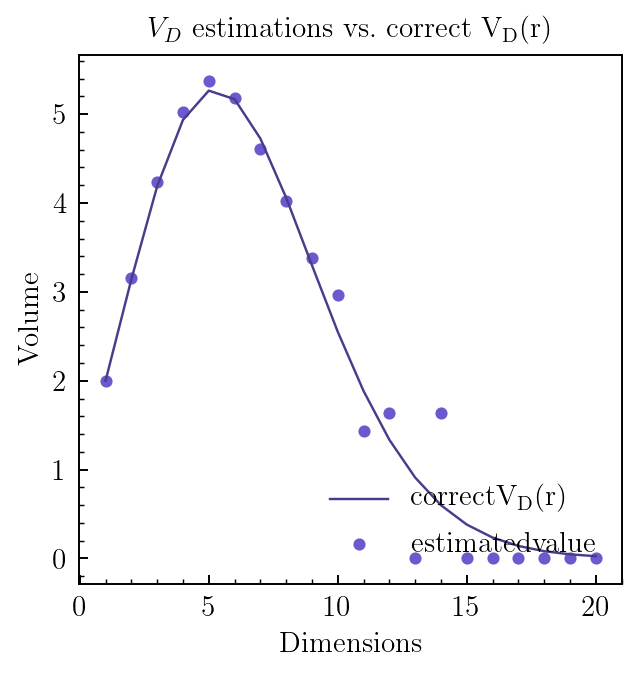

In [87]:
plot_line_points(dims, trueVol, 
                 xlabel=r'$\rm Dimensions$', ylabel=r'\rm Volume', 
                 xp=dims, yp=estVol, figsize=4, points=True,
                 legend=r'$\rm correct V_D(r)$',
                 plegend = r'$\rm estimated value$',
                 plot_title=r'$V_D\ \rm estimations\ vs.\ correct\ V_D(r)$')


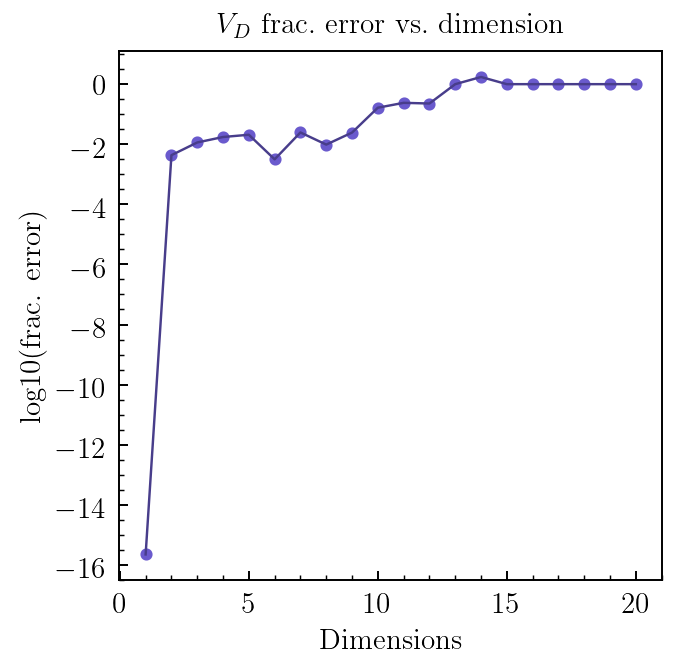

In [94]:
estVol = np.asarray(estVol)
trueVol = np.asarray(trueVol)
frac_diff = np.maximum(1./2**52,abs(1-np.divide(estVol,trueVol)))
plot_line_points(dims, np.log10(frac_diff), 
                 xlabel=r'$\rm Dimensions$', ylabel=r'\rm log10(frac. error)', 
                 xp=dims, yp=np.log10(frac_diff), figsize=4, points=True,
                 plot_title=r'$V_D\ \rm frac.\ error\ vs.\ dimension$')

#### Task 2c.  Dependence of the estimate accuracy on <tt>nrnd</tt> (3 points)

Fix $D$ and $r$ to the values you like and compute the absolute value of the fractional difference of your estimate from the correct result, $\epsilon=\vert 1-V_{\rm D,est}/V_{\rm D, exact}\vert$ for a series of <tt>nrnd</tt>. Plot $\epsilon$ as a function of <tt>nrnd</tt>. Discuss the trend you observe and your interpretation of it. 

When fixing $D=6$ and $r=1$, the fractional error seems to overall be inversely proportional to <tt>nrnd</tt> (downward trend). Although the data is relatively noisy because the MCMC method still relies on randomness which introduces error, even when many data points are used, it makes sense that we are able to obtain a more accurate estimate using a larger number of Monte Carlo estimates in the sample.

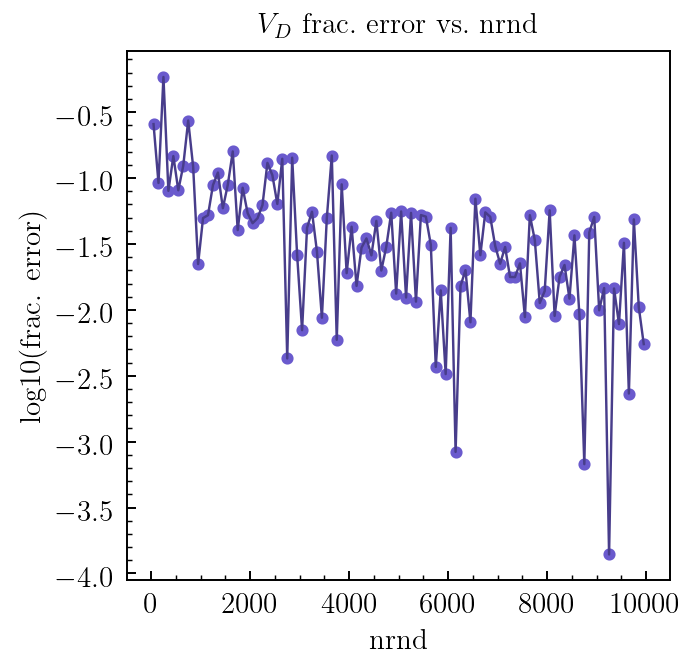

In [106]:
#fixing dim = 6, r = 1
d = 6
nrnds = np.arange(50,10000,step=100)
estVol = []
error = []
exact = dsphere_volume_exact(r=1,dim=d)

for rand in nrnds:
    est = volD(rad,d,rand)
    estVol.append(est)
    error.append(np.maximum(1./2**52,abs(1.-(est/exact))))
    
estVol = np.asarray(estVol)
error = np.asarray(error)
plot_line_points(nrnds, np.log10(error), 
                 xlabel=r'$\rm nrnd$', ylabel=r'\rm log10(frac. error)', 
                 xp=nrnds, yp=np.log10(error), figsize=4, points=True,
                 plot_title=r'$V_D\ \rm frac.\ error\ vs.\ nrnd$')

### Exercise 3 (extra-credit): Implementing the affine-invariant MCMC algorithm of Goodman & Weare (2010) (20 points). 


#### Task.
Implement the "affine-invariant" MCMC algorithm proposed by <a href="http://msp.org/camcos/2010/5-1/p04.xhtml">Goodman & Weare (2010, hereafter GW10)</a> and discussed in <tt>06d_multid_sampling_mcmc.ipynb</tt></a> notebook in the form of a python routine similar to routine <tt>vectorized_mcmc</tt> that you can find in the above notebook (feel free to use <tt>vectorized_mcmc</tt> as a basis for your routine). The GW10 algorithm has quite a few similarities to the differential evolution algorithm. Although implementing it may be a bit more involved, the effort should be comparable to implementing DE routine. 

Your routine should take on input a function calculating the target posterior pdf and a specified number of walkers (chains) initialized in some way (write a separate initialization routine, where initialization could be easily changed).

Specific implementation you should use is given by the Algorithm 2 or Algorithm 3 of <a href="http://adsabs.harvard.edu/abs/2013PASP..125..306F">Foreman-Mackey et al. (2010)</a>. If you implement Algorithm 3, it can be fairly easily parallelized later on using MPI library for parallel execution. Not strictly needed, but you can also think about a way to specify which dimensions of the parameter space can be "walked on" and which are kept fixed at their initial values. This will make the use of the routine convenient for inference when you want to fix certain parameters at the initial values and only fit the rest. (15 points)

***Hint:*** Note that the algorithm requires sampling of $z_r$ from a $g(x)$ distribution that you should have implemented in hw 4.


#### Required test:
Test your implementation of GW10 sampler against the Metropolis algorithm implemented in the <tt>vectorized_mcmc</tt> routine or <tt>emcee</tt> package for a 2D Gaussian pdf. Compare their acceptance ratios. After this test is passed you can also test your routine by sampling unnormalized posterior distribution in exercise 1 above.   (5 points)
